## Import libraries and choose device

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import math
import easydict
import gc
import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

from dataset.dataloader import load_data, get_loader
from dataset.field import Vocab
from utils import seq2sen

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = "cuda"
else:
    device = "cpu"
# device = "cpu"
print(f"Use {device} for torch")

Use cuda for torch


## Define Encoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, model_dim, h, N):
        super().__init__()
        self.model_dim = model_dim
        self.h = h
        self.N = N
        self.layers = nn.ModuleList([copy.deepcopy(EncoderIdenticalLayer(self.model_dim, self.h)) for _ in range(self.N)]).to(device)
    
    def forward(self, x, src_mask):
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

class EncoderIdenticalLayer(nn.Module):
    def __init__(self, model_dim, h):
        super().__init__()
        self.model_dim = model_dim
        self.h = h

        self.w_i_Q_list = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h).to(device) for _ in range(self.h)]
        self.w_i_K_list = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h).to(device) for _ in range(self.h)]
        self.w_i_V_list = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h).to(device) for _ in range(self.h)]
        self.w_O = nn.Linear(in_features = self.model_dim, out_features = self.model_dim).to(device)
        self.layer_normalization1 = nn.LayerNorm(self.model_dim).to(device) # exclude batch dimension

        self.feed_forward_network1 = nn.Linear(in_features = 512, out_features = 2048).to(device)
        self.feed_forward_network2 = nn.Linear(in_features = 2048, out_features = 512).to(device)
        self.layer_normalization2 = nn.LayerNorm(self.model_dim).to(device)

        self.dropout = nn.Dropout(p = 0.1).to(device)
        self.softmax = nn.Softmax(dim = 2).to(device)
        self.relu = nn.ReLU().to(device)

    def forward(self, x, src_mask):
        # Sublayer 1
        ## Multi-Head Attention
        splitted_x_list = []
        for i in range(self.h):
            in_softmax = torch.matmul(
                self.w_i_Q_list[i](x),
                self.w_i_K_list[i](x).transpose(1, 2)
            ) / math.sqrt(self.model_dim // self.h)
            in_softmax = in_softmax.masked_fill(src_mask == 0, -1e9)
            out_softmax = self.w_i_V_list[i](x)
            splitted_x = torch.matmul(self.softmax(in_softmax), out_softmax)
            splitted_x_list.append(splitted_x)
        concatenated_x = torch.cat(splitted_x_list, dim = 2)
        multi_head_attention_output = self.dropout(self.w_O(concatenated_x))

        ## Add & Layer Normalization
        multi_head_attention_output += x
        multi_head_attention_output = self.layer_normalization1(multi_head_attention_output)

        # Sublayer 2
        ## Position-wise Feed-Forward Network
        ffn_output = self.feed_forward_network1(multi_head_attention_output)
        ffn_output = self.relu(ffn_output)
        ffn_output = self.feed_forward_network2(ffn_output)
        ffn_output = self.dropout(ffn_output)

        ## Add & Layer Normalization
        ffn_output += multi_head_attention_output
        ffn_output = self.layer_normalization2(ffn_output)
        return ffn_output

## Define Decoder

In [5]:
class Decoder(nn.Module):
    def __init__(self, model_dim, h, N):
        super().__init__()
        self.model_dim = model_dim
        self.h = h
        self.N = N
        self.layers = nn.ModuleList([copy.deepcopy(DecoderIdenticalLayer(self.model_dim, self.h)) for _ in range(self.N)]).to(device)

    def forward(self, x, y, src_mask, tgt_mask): # x : decoder input, y : encoder output
        for layer in self.layers:
            x = layer(x, y, src_mask, tgt_mask)
        return x

class DecoderIdenticalLayer(nn.Module):
    def __init__(self, model_dim, h):
        super().__init__()
        self.model_dim = model_dim
        self.h = h

        self.w_i_Q_list_first = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h).to(device) for _ in range(self.h)]
        self.w_i_K_list_first = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h).to(device) for _ in range(self.h)]
        self.w_i_V_list_first = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h).to(device) for _ in range(self.h)]
        self.w_O_first = nn.Linear(in_features = self.model_dim, out_features = self.model_dim).to(device)
        self.layer_normalization1 = nn.LayerNorm(self.model_dim).to(device) # exclude batch dimension

        self.w_i_Q_list_second = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h).to(device) for _ in range(self.h)]
        self.w_i_K_list_second = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h).to(device) for _ in range(self.h)]
        self.w_i_V_list_second = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h).to(device) for _ in range(self.h)]
        self.w_O_second = nn.Linear(in_features = self.model_dim, out_features = self.model_dim).to(device)
        self.layer_normalization2 = nn.LayerNorm(self.model_dim).to(device) # exclude batch dimension
        
        self.feed_forward_network1 = nn.Linear(in_features = 512, out_features = 2048).to(device)
        self.feed_forward_network2 = nn.Linear(in_features = 2048, out_features = 512).to(device)
        self.layer_normalization3 = nn.LayerNorm(self.model_dim).to(device)

        self.dropout = nn.Dropout(p = 0.1).to(device)
        self.softmax = nn.Softmax(dim = 2).to(device)
        self.relu = nn.ReLU().to(device)

    def forward(self, x, y, src_mask, tgt_mask):
        # Sublayer 1
        ## Masked Multi-Head Attention
        splitted_x_list = []
        for i in range(self.h):
            in_softmax = torch.matmul(
                self.w_i_Q_list_first[i](x),
                self.w_i_K_list_first[i](x).transpose(1, 2)
            ) / math.sqrt(self.model_dim // self.h)
            in_softmax = in_softmax.masked_fill(tgt_mask == 0, -1e9)
            out_softmax = self.w_i_V_list_first[i](x)
            splitted_x = torch.matmul(self.softmax(in_softmax), out_softmax)
            splitted_x_list.append(splitted_x)
        concatenated_x = torch.cat(splitted_x_list, dim = 2)
        multi_head_attention_output_first = self.dropout(self.w_O_first(concatenated_x))

        ## Add & Layer Normalization
        multi_head_attention_output_first += x
        multi_head_attention_output_first = self.layer_normalization1(multi_head_attention_output_first)

        # Sublayer 2
        ## Multi-Head Attention
        """
        queries : come from previous decoder layer
        keys, values : come from the output of the encoder
        """
        splitted_x_list = []
        for i in range(self.h):
            in_softmax = torch.matmul(
                self.w_i_Q_list_second[i](multi_head_attention_output_first),
                self.w_i_K_list_second[i](y).transpose(1, 2)
            ) / math.sqrt(self.model_dim // self.h)
            in_softmax = in_softmax.masked_fill(src_mask == 0, -1e9)
            out_softmax = self.w_i_V_list_second[i](y)
            splitted_x = torch.matmul(self.softmax(in_softmax), out_softmax)
            splitted_x_list.append(splitted_x)
        concatenated_x = torch.cat(splitted_x_list, dim = 2)
        multi_head_attention_output_second = self.dropout(self.w_O_second(concatenated_x))

        ## Masked Multi-Head Attention
        multi_head_attention_output_second += multi_head_attention_output_first
        multi_head_attention_output_second = self.layer_normalization2(multi_head_attention_output_second)

        # Sublayer 3
        ## Feed-Forward Network
        ffn_output = self.feed_forward_network1(multi_head_attention_output_second)
        ffn_output = self.relu(ffn_output)
        ffn_output = self.feed_forward_network2(ffn_output)
        ffn_output = self.dropout(ffn_output)

        ## Add & Layer Normalization
        ffn_output += multi_head_attention_output_second
        ffn_output = self.layer_normalization3(ffn_output)
        return ffn_output

## Define Transformer

In [6]:
class Transformer(nn.Module):
    def __init__(self, model_dim, src_vocab_size, tgt_vocab_size, max_length):
        super().__init__()
        self.model_dim = model_dim
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.max_length = max_length
        self.h = 8
        self.N = 6

        self.positional_encoding_constants = self.get_positional_encoding_constants(model_dim = self.model_dim).to(device)
        self.input_embedding = nn.Embedding(num_embeddings = self.src_vocab_size, embedding_dim = self.model_dim, padding_idx = 2).to(device)
        self.output_embedding = nn.Embedding(num_embeddings = self.tgt_vocab_size, embedding_dim = self.model_dim, padding_idx = 2).to(device)
        self.embedding_dropout = nn.Dropout(p = 0.1).to(device)
        self.encoder = Encoder(self.model_dim, self.h, self.N).to(device)
        self.decoder = Decoder(self.model_dim, self.h, self.N).to(device)
        self.final_linear = nn.Linear(self.model_dim, self.tgt_vocab_size).to(device)

    def forward(self, encoder_input, decoder_input, src_mask, tgt_mask):
        encoder_input = self.embedding_dropout(self.positional_encoding(self.input_embedding(encoder_input) * math.sqrt(self.model_dim)))
        encoder_output = self.encoder(encoder_input, src_mask)
        decoder_output = self.decoder(self.embedding_dropout(self.positional_encoding(self.output_embedding(decoder_input) * math.sqrt(self.model_dim))), encoder_output, src_mask, tgt_mask)
        final_output = self.final_linear(decoder_output)
        return final_output

    def positional_encoding(self, embedded_sentence):
        encoding_result = embedded_sentence + self.positional_encoding_constants[:, :embedded_sentence.shape[1], :]
        return encoding_result
        
    def get_positional_encoding_constants(self, model_dim):
        # calculate positional encoding constants only once to avoid redundant calculations
        positional_encoding_constants = []
        for pos in range(self.max_length):
            pos_constants = []
            for idx in range(model_dim):
                if idx % 2 == 0: # idx = 2 * i -> 2 * i = idx
                    pos_constants.append(math.sin(pos / (10000 ** (idx / model_dim))))
                else: # idx = 2 * i + 1 -> 2 * i = idx - 1
                    pos_constants.append(math.cos(pos / (10000 ** ((idx  - 1) / model_dim))))
            positional_encoding_constants.append(pos_constants)
        return torch.tensor(positional_encoding_constants).unsqueeze(0)
    
    def save_model(self, output_path, epoch, loss, val_loss):
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        output_filename = os.path.join(output_path, f"weights_{epoch:03d}_{loss:.4f}_{val_loss:.4f}.pt")
        torch.save(self.state_dict(), output_filename)
        return output_filename

    def plot(self, output_path, history):
        plt.subplot(2, 1, 1)
        plt.title('Accuracy versus Epoch')
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.legend(['accuracy', 'val_accuracy'], loc = 'upper right')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

        plt.subplot(2, 1, 2)
        plt.title('Loss versus Epoch')
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.legend(['loss', 'val_loss'], loc = 'upper right')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "training_result.png"))

## Define loss function and some functions

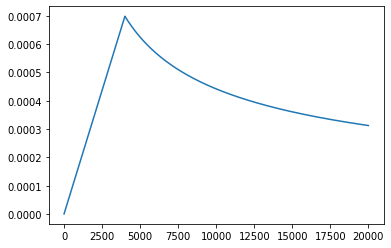

In [7]:
def get_mask(batch, pad_idx, is_target = False): # 0 : unavailable
    mask = (batch != pad_idx).unsqueeze(-2).to(device)
    if is_target:
        target_mask = torch.tensor(np.tril(np.ones((1, batch.size(-1), batch.size(-1)))), dtype = torch.bool).to(device)
        mask = mask & target_mask
    return mask

def get_learning_rate(model_dim, step_num, warmup_steps):
    return (model_dim ** (-0.5)) * min(step_num ** (-0.5), step_num * (warmup_steps ** (-1.5)))

plt.plot(np.arange(1, 20000), [get_learning_rate(512, i, 4000) for i in range(1, 20000)])

## Define main function



In [8]:
def main(args):
    src, tgt = load_data(args.path)

    src_vocab = Vocab(init_token='<sos>', eos_token='<eos>', pad_token='<pad>', unk_token='<unk>')
    src_vocab.load(os.path.join(args.path, 'vocab.en'))
    tgt_vocab = Vocab(init_token='<sos>', eos_token='<eos>', pad_token='<pad>', unk_token='<unk>')
    tgt_vocab.load(os.path.join(args.path, 'vocab.de'))

    sos_idx = 0
    eos_idx = 1
    pad_idx = 2
    max_length = 50

    src_vocab_size = len(src_vocab)
    tgt_vocab_size = len(tgt_vocab)

    print(src_vocab_size)
    print(tgt_vocab_size)
    
    # Define training parameters
    model_dim = 512
    warmup_steps = 4000

    # Define model
    transformer = Transformer(model_dim, src_vocab_size, tgt_vocab_size, max_length)
    for param in transformer.parameters():
        if param.dim() > 1:
            nn.init.xavier_uniform_(param)
    if args.test and args.model_path: # test
        transformer.load_state_dict(torch.load(args.model_path))
        transformer.eval()

    # Define optimizer
    step_num = 1
    learning_rate = get_learning_rate(model_dim, step_num, warmup_steps)
    optimizer = optim.Adam(transformer.parameters(), lr = learning_rate)

    # Define loss function
    train_loss_function = nn.CrossEntropyLoss(ignore_index = pad_idx).to(device)
    validation_loss_function = nn.CrossEntropyLoss(ignore_index = pad_idx).to(device)

    if not args.test:
        train_loader = get_loader(src['train'], tgt['train'], src_vocab, tgt_vocab, batch_size=args.batch_size, shuffle=True)
        valid_loader = get_loader(src['valid'], tgt['valid'], src_vocab, tgt_vocab, batch_size=args.batch_size)

        history = {
            "loss" : [],
            "val_loss" : [],
            "accuracy" : [],
            "val_accuracy" : []
        }

        for epoch in range(1, args.epochs + 1):
            print(f"Epoch {epoch}/{args.epochs}")
            total_train_size, total_validation_size = 0, 0
            epoch_train_loss, epoch_validation_loss = 0, 0
            epoch_train_correct, epoch_validation_correct = 0, 0

            for src_batch, tgt_batch in tqdm(train_loader):
            # for src_batch, tgt_batch in train_loader:
                # update learning rate first
                learning_rate = get_learning_rate(model_dim, step_num, warmup_steps)
                for g in optimizer.param_groups:
                    g['lr'] = learning_rate
                optimizer.zero_grad()

                src_mask = get_mask(torch.tensor(src_batch), pad_idx, is_target = False)
                tgt_mask = get_mask(torch.tensor(tgt_batch)[:, :-1], pad_idx, is_target = True)

                prd_batch = transformer(torch.tensor(src_batch).to(device), torch.tensor(tgt_batch)[:, :-1].to(device), src_mask.to(device), tgt_mask.to(device))
                loss = train_loss_function( \
                    torch.tensor(prd_batch.reshape(-1, tgt_vocab_size), dtype = torch.float, requires_grad = True).clone().to(device), \
                    torch.tensor(tgt_batch)[:, 1:].reshape(-1).clone().to(device) \
                )
                loss.backward()
                optimizer.step()
                step_num += 1

                total_train_size += len(src_batch)
                epoch_train_loss += loss.data
                epoch_train_correct += int(torch.sum(torch.argmax(torch.tensor(prd_batch).data, -1) == torch.tensor(tgt_batch).data[:, 1:].to(device)))

                gc.collect()
                if "cuda" in device:
                    torch.cuda.empty_cache()

            epoch_train_loss /= total_train_size
            epoch_train_accuracy = epoch_train_correct / total_train_size

            history["loss"].append(epoch_train_loss)    
            history["accuracy"].append(epoch_train_accuracy)

            for src_batch, tgt_batch in tqdm(valid_loader):
                src_mask = get_mask(torch.tensor(src_batch), pad_idx, is_target = False)
                tgt_mask = get_mask(torch.tensor(tgt_batch)[:, :-1], pad_idx, is_target = True)

                prd_batch = transformer(torch.tensor(src_batch).to(device), torch.tensor(tgt_batch)[:, :-1].to(device), src_mask.to(device), tgt_mask.to(device))
                loss = validation_loss_function( \
                    torch.tensor(prd_batch.reshape(-1, tgt_vocab_size), dtype = torch.float, requires_grad = True).clone().to(device), \
                    torch.tensor(tgt_batch)[:, 1:].reshape(-1).clone().to(device) \
                )

                total_validation_size += len(src_batch)
                epoch_validation_loss += loss.data
                epoch_validation_correct += int(torch.sum(torch.argmax(torch.tensor(prd_batch).data, -1) == torch.tensor(tgt_batch).data[:, 1:].to(device)))

                gc.collect()
                if "cuda" in device:
                    torch.cuda.empty_cache()

            epoch_validation_loss /= total_validation_size
            epoch_validation_accuracy = epoch_validation_correct / total_validation_size

            history["val_loss"].append(epoch_validation_loss)
            history["val_accuracy"].append(epoch_validation_accuracy)

            print(f"loss : {epoch_train_loss:.6f}, val_loss : {epoch_validation_loss:.6f}") 
            print(f"accuracy : {epoch_train_accuracy:.6f}, val_accuracy : {epoch_validation_accuracy:.6f}")

            transformer.save_model(args.output_path, epoch, epoch_train_loss, epoch_validation_loss)
            transformer.plot(args.output_path, history)

    else: # test
        test_loader = get_loader(src['test'], tgt['test'], src_vocab, tgt_vocab, batch_size=args.batch_size)

        pred = []
        for src_batch, tgt_batch in tqdm(test_loader):
            result_batch = torch.tensor([sos_idx for _ in range(len(src_batch))]).unsqueeze(-1)
            for idx in range(max_length):
                if idx == max_length - 1:
                    pred_batch = torch.full((len(src_batch), 1), eos_idx)
                else:
                    src_mask = get_mask(torch.tensor(src_batch), pad_idx, is_target = False)
                    result_mask = get_mask(torch.tensor(result_batch), pad_idx, is_target = True)

                    pred_batch = transformer(torch.tensor(src_batch).to(device), result_batch.to(device), src_mask.to(device), result_mask.to(device))[:, -1, :] # consider only last result
                    pred_batch[:, sos_idx] += -1e9 # exclude <sos>
                    pred_batch[:, pad_idx] += -1e9 # exclude <pad>
                    pred_batch = torch.argmax(pred_batch, dim = -1).unsqueeze(-1)
                result_batch = torch.cat((result_batch.to(device), pred_batch.to(device)), dim = -1)
            result_batch = result_batch[1:, :] # remove <sos> from the result

            max_length = 0
            for batch_idx in range(result_batch.shape[0]):
                max_length = max(max_length, list(result_batch[batch_idx]).index(eos_idx)) # find <eos>
            result_batch = result_batch[:max_length, :].tolist()
            pred += seq2sen(result_batch, tgt_vocab)

            gc.collect()
            if "cuda" in deivce:
                torch.cuda.empty_cache()

        with open('results/pred.txt', 'w') as f:
            for line in pred:
                f.write('{}\n'.format(line))
            f.close()

        os.system('bash scripts/bleu.sh results/pred.txt multi30k/test.de.atok')

## Run main function

In [9]:
args = easydict.EasyDict({
    "path": "multi30k",
    "epochs": 100,
    "batch_size": 32,
    "test": False,
    "output_path": "resources",
    "model_path": "resources/weights_010_0.0663_0.0668.pt"
})

main(args)

3935
4376
Epoch 1/100


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
80it [00:15,  5.29it/s]


KeyboardInterrupt: 